In [28]:
!pip install ultralytics

In [29]:
import torch
print("="*50)
print("GPU VERIFICATION")
print("="*50)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"GPU Count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
    print(f"Current GPU: {torch.cuda.current_device()}")
else:
    print("⚠️ WARNING: CUDA not available! Training will be slow on CPU")
print("="*50)

GPU VERIFICATION
PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version: 12.1
GPU Count: 1
GPU 0: Quadro P620
  Memory: 4.29 GB
Current GPU: 0


In [30]:
import torch
print("="*50)
print("GPU VERIFICATION")
print("="*50)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"GPU Count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9:.2f} GB")
    print(f"Current GPU: {torch.cuda.current_device()}")
else:
    print("⚠️ WARNING: CUDA not available! Training will be slow on CPU")
print("="*50)

# Set a global `device` variable for the notebook to use everywhere
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_device = torch.device(device)
print(f"Notebook device set to: {device}")
if device == "cuda":
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True


GPU VERIFICATION
PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version: 12.1
GPU Count: 1
GPU 0: Quadro P620
  Memory: 4.29 GB
Current GPU: 0
Notebook device set to: cuda


In [ ]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm
import shutil

# Source and target directories
SOURCE_DIR = "data"              # original images (will be backed up)
TARGET_DIR = "data"              # where resized images will be saved (overwrites)
BACKUP_DIR = "data_backup"      # backup of originals before overwrite
os.makedirs(TARGET_DIR, exist_ok=True)

# 🔥 segmentation model (keep this as before)
model = YOLO("yolov8n-seg.pt")

# Standard size compatible with YOLO/segmentation (use 1024×1024)
STANDARD_SIZE = (1024, 1024)

print("📐 Standardizing all images to same size and saving into data/ (backing up originals)...")
resized_dir = os.path.join(TARGET_DIR, "resized_temp")
os.makedirs(resized_dir, exist_ok=True)

# Create backup of original images only if it doesn't already exist
if not os.path.exists(BACKUP_DIR):
    os.makedirs(BACKUP_DIR, exist_ok=True)
    print(f"Creating backup of originals into {BACKUP_DIR}...")
    for file in os.listdir(SOURCE_DIR):
        src = os.path.join(SOURCE_DIR, file)
        if os.path.isfile(src) and file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            shutil.copy2(src, os.path.join(BACKUP_DIR, file))
    print("Backup complete.")

resized_files = []
for file in tqdm(os.listdir(SOURCE_DIR), desc="Resizing images"):
    path = os.path.join(SOURCE_DIR, file)
    if not os.path.isfile(path) or not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        continue
    img = cv2.imread(path)
    if img is None:
        continue
    # Resize to the standard size (preserve aspect by padding or center-cropping could be added later)
    img_resized = cv2.resize(img, STANDARD_SIZE, interpolation=cv2.INTER_AREA)
    resized_path = os.path.join(resized_dir, file)
    cv2.imwrite(resized_path, img_resized)
    resized_files.append(file)

# Overwrite target data/ with resized images
for f in resized_files:
    src = os.path.join(resized_dir, f)
    dst = os.path.join(TARGET_DIR, f)
    shutil.move(src, dst)

# Cleanup temp directory
shutil.rmtree(resized_dir, ignore_errors=True)

print(f"✅ Resized {len(resized_files)} images to {STANDARD_SIZE} and saved into {TARGET_DIR}")

📐 Standardizing all images to same size and saving into data/ (backing up originals)...


Resizing images:  36%|███▌      | 703/1943 [00:09<00:17, 72.19it/s]

In [ ]:
# Crop cars from all images in `data/` using YOLO and save to `clean_cars/`
import os
import cv2
from ultralytics import YOLO
from tqdm import tqdm
import numpy as np
import shutil

INPUT_DIR = "data"
CLEAN_DIR = "clean_cars"
os.makedirs(CLEAN_DIR, exist_ok=True)

# Detector model (segmentation-capable)
detector = YOLO("yolov8n-seg.pt")

files = sorted([f for f in os.listdir(INPUT_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
if not files:
    print(f"No images found in {INPUT_DIR} to crop.")
else:
    saved = 0
    for fname in tqdm(files, desc="Cropping cars to clean_cars"):
        path = os.path.join(INPUT_DIR, fname)
        img = cv2.imread(path)
        if img is None:
            continue
        try:
            results = detector(img, conf=0.3, classes=[2], device=device, verbose=False)  # class 2 = car
            r = results[0]
            if hasattr(r, 'boxes') and len(r.boxes):
                boxes = r.boxes.xyxy.cpu().numpy()
                areas = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
                idx = int(np.argmax(areas))
                x1, y1, x2, y2 = boxes[idx].astype(int)
                h, w = img.shape[:2]
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)
                if x2 - x1 < 16 or y2 - y1 < 16:
                    # bounding box too small, fallback to full image
                    crop = img
                else:
                    crop = img[y1:y2, x1:x2]
            else:
                # no car detected, save full image so downstream steps have data
                crop = img
        except Exception as e:
            print(f"Error processing {fname}: {e}")
            crop = img
        out_path = os.path.join(CLEAN_DIR, fname)
        cv2.imwrite(out_path, crop)
        saved += 1
    print(f"✅ Saved {saved} images to {CLEAN_DIR} (cropped where cars detected)")

Cropping cars to clean_cars: 100%|██████████| 1942/1942 [01:12<00:00, 26.91it/s]

✅ Saved 1942 images to clean_cars (cropped where cars detected)


Saved sample visualization to segmentation_results/clean_cars_sample.png


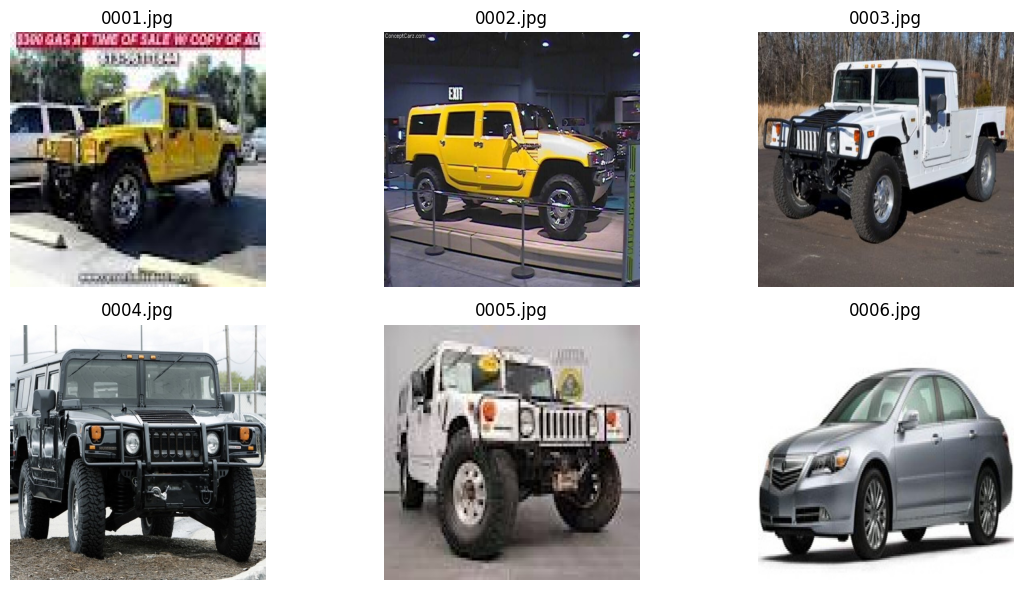

In [20]:
# Visualize a few sample images from `clean_cars/`
import os
import glob
import cv2
import matplotlib.pyplot as plt
from math import ceil

folder = 'clean_cars'
os.makedirs('segmentation_results', exist_ok=True)
paths = sorted(glob.glob(os.path.join(folder, '*.*')))
if not paths:
    print('No images found in', folder)
else:
    n = min(6, len(paths))
    samples = paths[:n]
    cols = 3
    rows = ceil(n / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axs = axs.flatten()
    for ax, path in zip(axs, samples):
        img = cv2.imread(path)
        if img is None:
            ax.set_title(os.path.basename(path) + ' (failed to load)')
            ax.axis('off')
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(os.path.basename(path))
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')
    plt.tight_layout()
    out = 'segmentation_results/clean_cars_sample.png'
    plt.savefig(out, dpi=150, bbox_inches='tight')
    print('Saved sample visualization to', out)
    plt.show()


In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import random
import numpy as np
import cv2
import os

class DentedCarDataset(Dataset):
    """Dataset for pre-augmented dented car images"""
    def __init__(self, dented_dir, img_size=256, clean_dir=None):
        self.dented_dir = dented_dir
        self.clean_dir = clean_dir
        self.img_size = img_size
        
        # Get all dented images
        self.dented_files = sorted([f for f in os.listdir(dented_dir) 
                                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
        
        print(f"Loaded {len(self.dented_files)} dented images from {dented_dir}")
        
        self.transform = T.Compose([
            T.Resize((img_size, img_size)),
            T.ToTensor()
        ])

    def __getitem__(self, idx):
        dented_file = self.dented_files[idx]
        dented_path = os.path.join(self.dented_dir, dented_file)
        dented_img = cv2.imread(dented_path)
        
        if dented_img is None:
            dented_img = np.ones((256, 256, 3), dtype=np.uint8) * 128
        
        dented_img = cv2.cvtColor(dented_img, cv2.COLOR_BGR2RGB)
        
        # Extract original image name (remove dent type suffix)
        name_parts = dented_file.rsplit('_', 1)[0]
        
        # Find corresponding clean image
        clean_img = None
        if self.clean_dir:
            for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
                clean_path = os.path.join(self.clean_dir, name_parts + ext)
                if os.path.exists(clean_path):
                    clean_img = cv2.imread(clean_path)
                    clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)
                    break
        
        # Fallback: if no clean image found, use the original
        if clean_img is None:
            # Try to find original in data folder
            for ext in ['.png', '.jpg', '.jpeg', '.bmp']:
                orig_path = os.path.join("data", name_parts + ext)
                if os.path.exists(orig_path):
                    clean_img = cv2.imread(orig_path)
                    clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)
                    break
        
        # If still no clean image, use dented as fallback
        if clean_img is None:
            clean_img = dented_img.copy()
        
        dented_pil = Image.fromarray(dented_img)
        clean_pil = Image.fromarray(clean_img)
        
        return self.transform(dented_pil), self.transform(clean_pil)
    
    def __len__(self):
        return len(self.dented_files)

In [22]:
import torch.nn as nn
import torchvision.models


def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)

        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)
        return out

In [23]:
import torch.nn.functional as F
import torchvision.models as models

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()

        vgg = models.vgg16(pretrained=True).features[:16].eval()
        for param in vgg.parameters():
            param.requires_grad = False

        self.vgg = vgg

        # ImageNet normalization
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

    def forward(self, pred, target):

        # Normalize to ImageNet stats
        self.mean = self.mean.to(pred.device)
        self.std = self.std.to(pred.device)

        pred = (pred - self.mean) / self.std
        target = (target - self.mean) / self.std

        pred_features = self.vgg(pred)
        target_features = self.vgg(target)

        loss = F.l1_loss(pred_features, target_features)

        return loss

In [27]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from dents import (apply_radial_dent, apply_creased_dent, apply_hail_damage, 
                   apply_wave_dent, apply_depth_dent, apply_scratch_dent, random_bbox)

# Define all 6 dent functions
dent_functions = [
    ("radial", apply_radial_dent),
    ("creased", apply_creased_dent),
    ("hail", apply_hail_damage),
    ("wave", apply_wave_dent),
    ("depth", apply_depth_dent),
    ("scratch", apply_scratch_dent),
]

# Input and output directories
input_dir = "clean_cars"  # corrected to local clean_cars folder
augmented_dir = "data_augmented"
os.makedirs(augmented_dir, exist_ok=True)

# Get all images from data folder
image_files = [f for f in os.listdir(input_dir) 
               if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

print(f"📊 Found {len(image_files)} original images")
print(f"🔄 Creating 6 augmented versions of each image...")
print(f"📈 Expected total: {len(image_files) * 6} augmented images\n")

total_saved = 0

# For each original image
for img_file in tqdm(image_files, desc="Augmenting images"):
    img_path = os.path.join(input_dir, img_file)
    img = cv2.imread(img_path)
    
    if img is None:
        continue
    
    # Get filename without extension
    name, ext = os.path.splitext(img_file)
    
    # Apply each dent function
    for dent_name, dent_func in dent_functions:
        try:
            # Generate center-positioned dent bbox (45-55% of image = half size, centered)
            bbox = random_bbox(img)
            
            # Apply dent with VERY STRONG intensity
            dented_img = img.copy()
            if dent_name == "hail":
                dented_img = dent_func(dented_img, bbox, num_dents=random.randint(120, 180))
            else:
                strength = np.random.uniform(400, 600)
                dented_img = dent_func(dented_img, bbox, strength=int(strength))
            
            # Save augmented image
            output_filename = f"{name}_{dent_name}{ext}"
            output_path = os.path.join(augmented_dir, output_filename)
            cv2.imwrite(output_path, dented_img)
            total_saved += 1
            
        except Exception as e:
            print(f"Error processing {img_file} with {dent_name}: {e}")
            continue

print(f"\n✅ Augmentation complete!")
print(f"📁 Saved {total_saved} augmented images to '{augmented_dir}'")
print(f"Original: {len(image_files)} → Augmented: {total_saved}")

📊 Found 1942 original images
🔄 Creating 6 augmented versions of each image...
📈 Expected total: 11652 augmented images



Augmenting images:   2%|▏         | 38/1942 [01:13<1:01:08,  1.93s/it]


KeyboardInterrupt: 

In [ ]:
# Segment augmented training images and save masks + overlays
import os
import glob
import cv2
import numpy as np
from ultralytics import YOLO

MODEL_PATH = 'yolov11-seg-cardd.pt'
out_mask_dir = 'segmentation_results/train_masks'
out_overlay_dir = 'segmentation_results/train_overlays'

os.makedirs(out_mask_dir, exist_ok=True)
os.makedirs(out_overlay_dir, exist_ok=True)

paths = sorted(glob.glob(os.path.join('data_augmented', '*.*')))
if not paths:
    print('No images found in data_augmented/.')
else:
    if not os.path.exists(MODEL_PATH):
        print(f'Model {MODEL_PATH} not found. Please download it first (e.g. yolov11-seg-cardd.pt).')
    else:
        seg_model = YOLO(MODEL_PATH)
        processed = 0
        for p in paths:
            try:
                res = seg_model.predict(source=p, imgsz=1024, conf=0.25, device=device, verbose=False)[0]
            except Exception:
                res = seg_model(p, imgsz=1024, device=device)[0]

            # Build a single binary mask (union of all predicted masks)
            mask = None
            if hasattr(res, 'masks') and res.masks is not None:
                try:
                    mdata = res.masks.data.cpu().numpy()
                except Exception:
                    try:
                        mdata = np.array(res.masks)
                    except Exception:
                        mdata = None
                if mdata is not None:
                    mask = (np.any(mdata, axis=0) * 255).astype(np.uint8)

            img = cv2.imread(p)
            if img is None:
                continue
            h, w = img.shape[:2]

            if mask is None:
                # fallback to empty mask
                mask = np.zeros((h, w), dtype=np.uint8)
            else:
                if mask.shape != (h, w):
                    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

            base = os.path.splitext(os.path.basename(p))[0]
            mask_path = os.path.join(out_mask_dir, base + '_mask.png')
            overlay_path = os.path.join(out_overlay_dir, base + '_overlay.png')
            cv2.imwrite(mask_path, mask)

            # create overlay (red mask)
            colored = img.copy()
            colored[mask > 0] = (0, 0, 255)
            blended = cv2.addWeighted(img, 0.7, colored, 0.3, 0)
            cv2.imwrite(overlay_path, blended)

            processed += 1
        print(f'Saved {processed} masks to {out_mask_dir} and overlays to {out_overlay_dir}')


In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

dataset_vis = DentedCarDataset("data_augmented", clean_dir="clean_cars")  # Load augmented dented images with clean pairs

num_examples = 3
plt.figure(figsize=(12, 4 * num_examples))

for i in range(num_examples):
    idx = random.randint(0, len(dataset_vis) - 1)
    dented, clean = dataset_vis[idx]

    dented_img = dented.permute(1, 2, 0).numpy()
    clean_img = clean.permute(1, 2, 0).numpy()

    dented_img = np.clip(dented_img, 0, 1)
    clean_img = np.clip(clean_img, 0, 1)

    diff = np.abs(dented_img - clean_img).mean(axis=2)

    plt.subplot(num_examples, 3, i * 3 + 1)
    plt.imshow(clean_img)
    plt.title("Clean Car")
    plt.axis("off")

    plt.subplot(num_examples, 3, i * 3 + 2)
    plt.imshow(dented_img)
    plt.title("Synthetic Dented")
    plt.axis("off")

    plt.subplot(num_examples, 3, i * 3 + 3)
    plt.imshow(diff, cmap="hot")
    plt.title("Dent Difference Map")
    plt.axis("off")

plt.tight_layout()
plt.show()


🚀 Using device: cuda
✅ GPU: Quadro P620
✅ cuDNN enabled and benchmarking activated
Loaded 10086 dented images from data_augmented
📊 Dataset size: 10086 augmented images
📂 Loading checkpoint...


C:\Users\My PC\AppData\Local\Temp\ipykernel_14316\558411635.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

✅ Resumed from epoch 50

Training on 10086 augmented images
Device: cuda | Batch Size: 8

Epoch  51/70 | Loss: 0.0208 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 51
Epoch  52/70 | Loss: 0.0196 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 52
Epoch  53/70 | Loss: 0.0190 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 53
Epoch  54/70 | Loss: 0.0186 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 54
Epoch  55/70 | Loss: 0.0183 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 55
Epoch  56/70 | Loss: 0.0181 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 56
Epoch  57/70 | Loss: 0.0179 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 57
Epoch  58/70 | Loss: 0.0177 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 58
Epoch  59/70 | Loss: 0.0175 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 59
Epoch  60/70 | Loss: 0.0174 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 60

📊 Generating visualization for epoch 60...



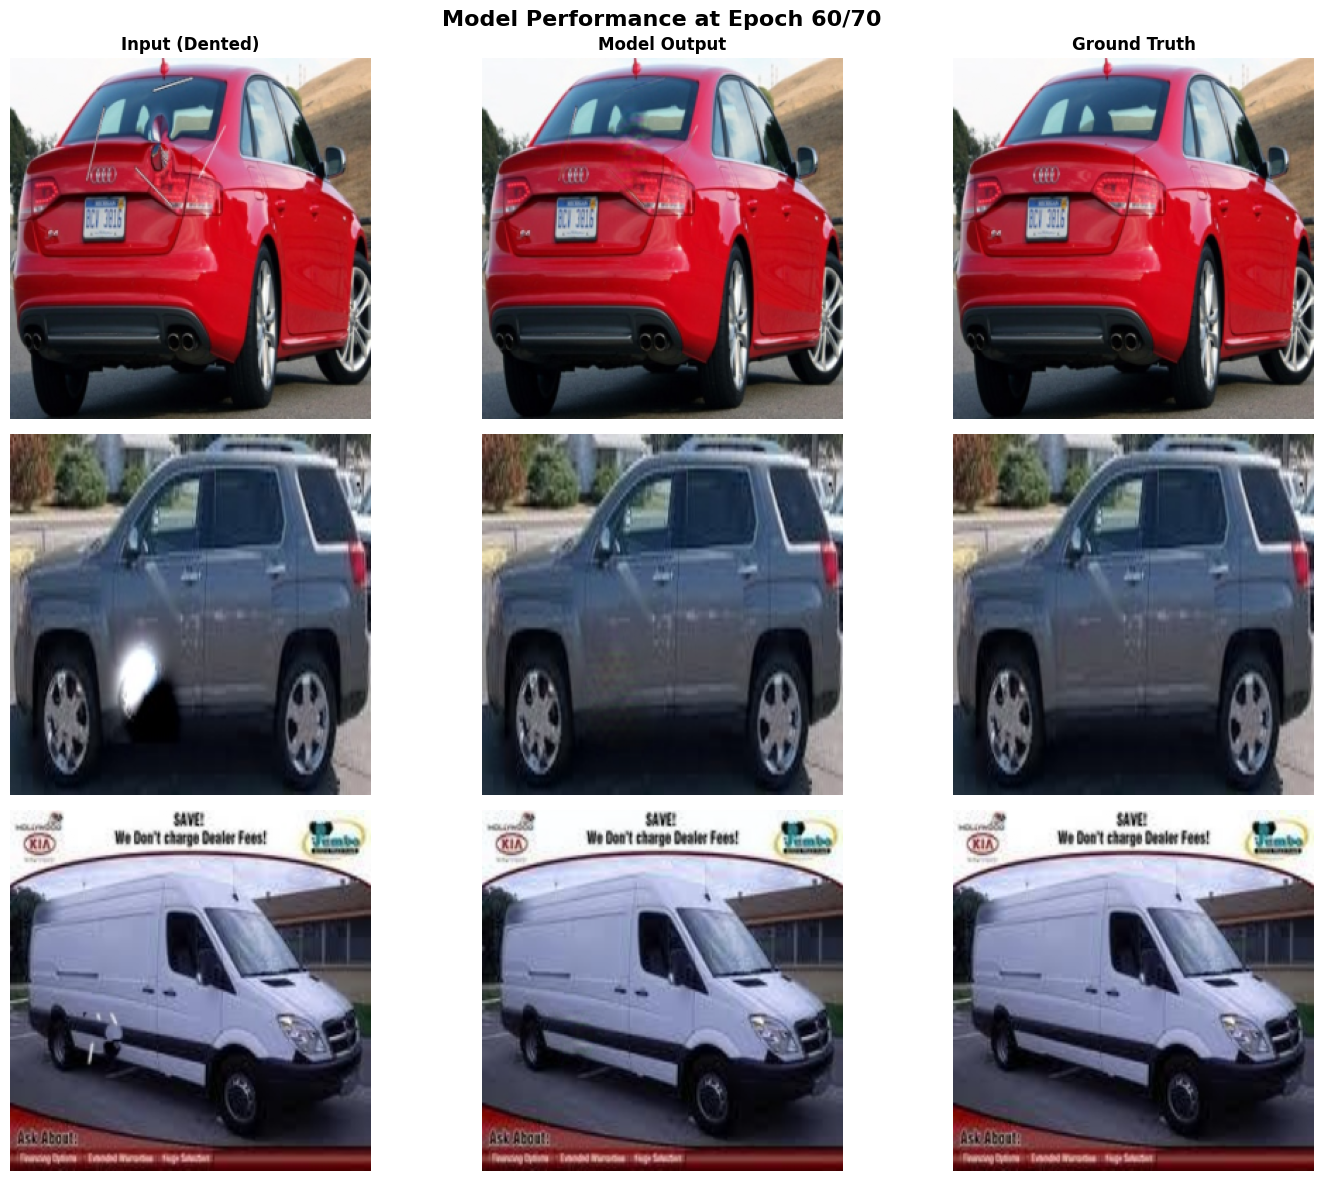


Epoch  61/70 | Loss: 0.0172 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 61
Epoch  62/70 | Loss: 0.0170 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 62
Epoch  63/70 | Loss: 0.0170 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 63
Epoch  64/70 | Loss: 0.0168 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 64
Epoch  65/70 | Loss: 0.0169 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 65
Epoch  66/70 | Loss: 0.0167 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 66
Epoch  67/70 | Loss: 0.0165 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 67
Epoch  68/70 | Loss: 0.0165 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 68
Epoch  69/70 | Loss: 0.0164 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 69
Epoch  70/70 | Loss: 0.0163 | GPU Mem: 0.46 GB
💾 Checkpoint saved at epoch 70

📊 Generating visualization for epoch 70...



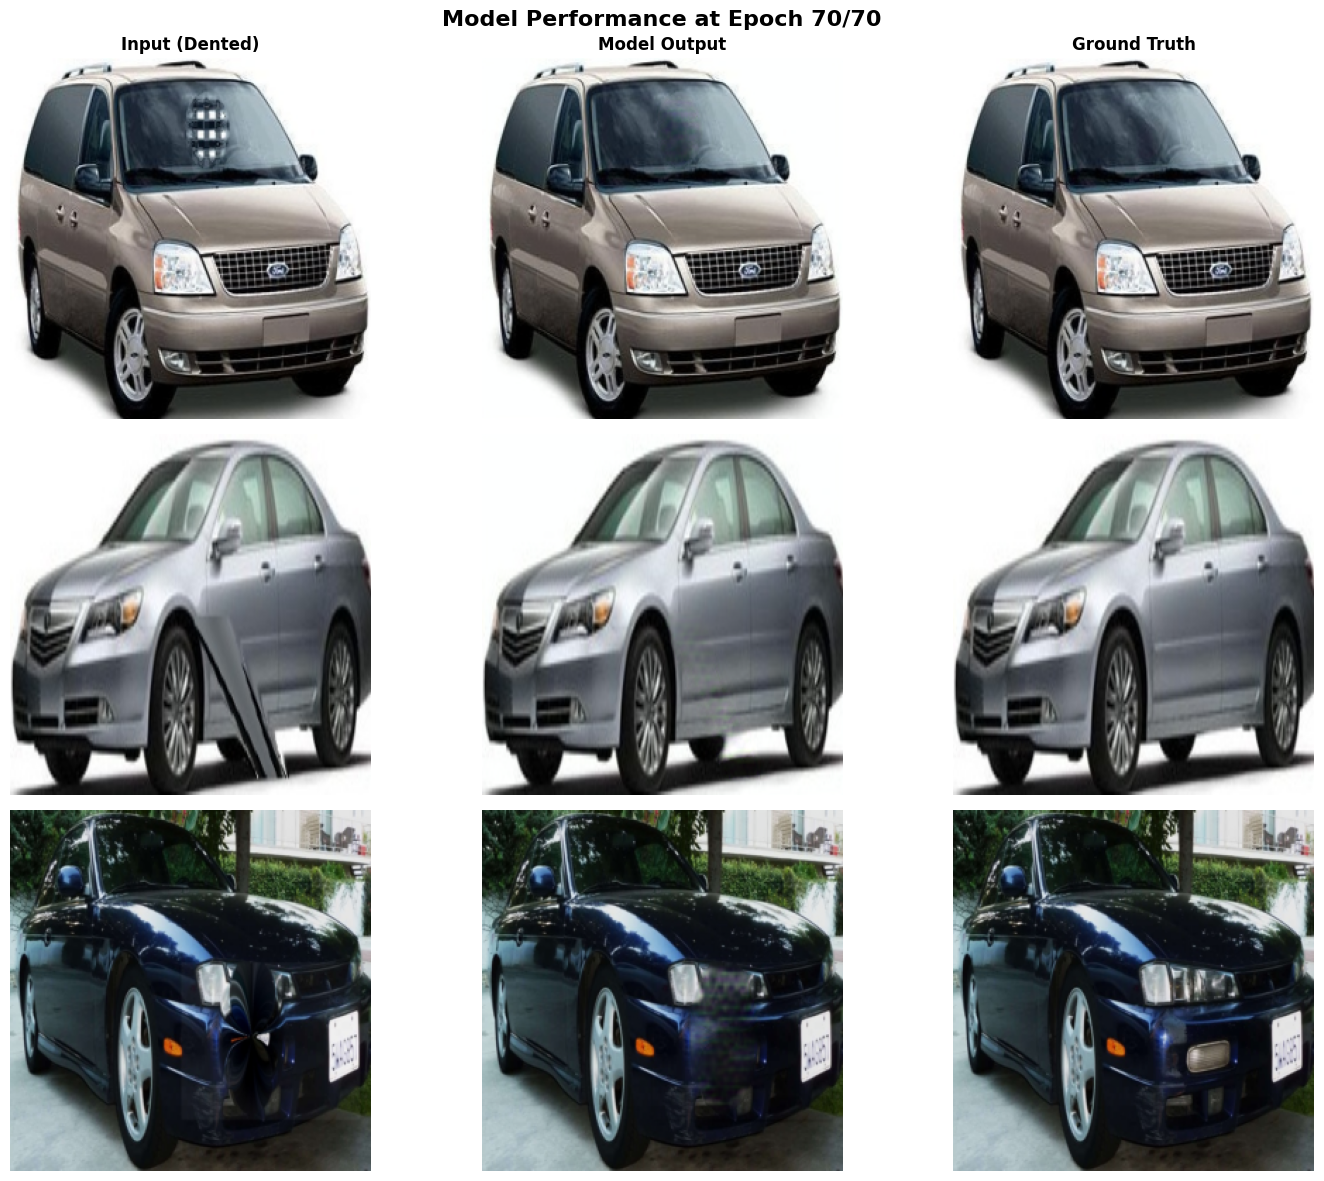



✅ Training complete!

📊 GPU Statistics:
  Peak Memory Allocated: 3.44 GB
  Peak Memory Reserved: 4.51 GB


In [ ]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🚀 Using device: {device}")

if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    print("✅ cuDNN enabled and benchmarking activated")

# Use augmented dataset
augmented_dir = "data_augmented"
if not os.path.exists(augmented_dir) or len(os.listdir(augmented_dir)) == 0:
    print(f"❌ Error: {augmented_dir} not found or empty!")
    print("Please run the augmentation cell first.")
else:
    dataset = DentedCarDataset(augmented_dir, clean_dir="clean_cars")
    print(f"📊 Dataset size: {len(dataset)} augmented images")
    
    # Batch size for GPU
    batch_size = 8
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    
    model = ResNetUNet(n_class=3).to(device)
    pixel_loss = nn.L1Loss().to(device)
    perceptual_loss = VGGPerceptualLoss().to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    # Checkpoint saving
    checkpoint_dir = "checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, "dent_removal_model.pt")
    start_epoch = 0
    
    if os.path.exists(checkpoint_path):
        print("📂 Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"✅ Resumed from epoch {start_epoch}")
    else:
        print("🆕 Starting fresh training")
    
    num_epochs = 70
    
    print(f"\n{'='*60}")
    print(f"Training on {len(dataset)} augmented images")
    print(f"Device: {device} | Batch Size: {batch_size}")
    print(f"{'='*60}\n")
    
    # Track loss history for visualization
    loss_history = []
    epoch_list = []
    
    for epoch in range(start_epoch, num_epochs):
        model.train()
        
        total_loss = 0
        batch_count = 0
    
        for dented, clean in loader:
            dented, clean = dented.to(device), clean.to(device)
    
            pred = model(dented)
            loss = pixel_loss(pred, clean) + 0.1 * perceptual_loss(pred, clean)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
            batch_count += 1
    
        avg_loss = total_loss / batch_count if batch_count>0 else 0.0
        loss_history.append(avg_loss)
        epoch_list.append(epoch+1)
        print(f"Epoch {epoch+1:3d}/{num_epochs} | Loss: {avg_loss:.4f}", end="")
        
        # GPU memory usage
        if torch.cuda.is_available():
            gpu_mem = torch.cuda.memory_allocated() / 1e9
            print(f" | GPU Mem: {gpu_mem:.2f} GB", end="")
        print()
        
        # Save checkpoint every 10 epochs
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss
            }, checkpoint_path)
        print(f"💾 Checkpoint saved at epoch {epoch+1}")
        
        # Visualize results every 10 epochs
        if (epoch + 1) % 10 == 0:
            model.eval()
            print(f"\n📊 Generating visualization for epoch {epoch+1}...\n")
            
            with torch.no_grad():
                fig, axes = plt.subplots(3, 3, figsize=(15, 12))
                fig.suptitle(f'Model Performance at Epoch {epoch+1}/{num_epochs}', fontsize=16, fontweight='bold')
                
                for i in range(3):
                    # Get random sample from dataset
                    idx = random.randint(0, len(dataset) - 1)
                    dented, clean = dataset[idx]
                    
                    input_tensor = dented.unsqueeze(0).to(device)
                    pred = model(input_tensor)[0].cpu()
                    
                    dented_img = dented.permute(1, 2, 0).numpy()
                    clean_img = clean.permute(1, 2, 0).numpy()
                    pred_img = pred.permute(1, 2, 0).numpy()
                    
                    dented_img = np.clip(dented_img, 0, 1)
                    clean_img = np.clip(clean_img, 0, 1)
                    pred_img = np.clip(pred_img, 0, 1)
                    
                    # Input (Dented)
                    axes[i, 0].imshow(dented_img)
                    axes[i, 0].set_title('Input (Dented)' if i == 0 else '', fontsize=12, fontweight='bold')
                    axes[i, 0].axis('off')
                    
                    # Predicted output
                    axes[i, 1].imshow(pred_img)
                    axes[i, 1].set_title('Model Output' if i == 0 else '', fontsize=12, fontweight='bold')
                    axes[i, 1].axis('off')
                    
                    # Ground truth
                    axes[i, 2].imshow(clean_img)
                    axes[i, 2].set_title('Ground Truth' if i == 0 else '', fontsize=12, fontweight='bold')
                    axes[i, 2].axis('off')
                
                plt.tight_layout()
                plt.show()
            
            model.train()  # Switch back to training mode
            print()
    
    print("\n✅ Training complete!")
    
    # Final GPU stats
    if torch.cuda.is_available():
        print(f"\n📊 GPU Statistics:")
        print(f"  Peak Memory Allocated: {torch.cuda.max_memory_allocated() / 1e9:.2f} GB")
        print(f"  Peak Memory Reserved: {torch.cuda.max_memory_reserved() / 1e9:.2f} GB")
    
    # Plot loss curve and save
    try:
        plt.figure(figsize=(8,4))
        plt.plot(epoch_list, loss_history, marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Average Loss')
        plt.title('Training Loss Curve')
        plt.grid(True)
        loss_fig_path = os.path.join(checkpoint_dir, 'loss_curve.png')
        plt.savefig(loss_fig_path, bbox_inches='tight')
        plt.show()
        print(f"Saved training loss curve to {loss_fig_path}")
    except Exception as e:
        print('Could not plot/save loss curve:', e)

Loaded 10086 dented images from data_augmented


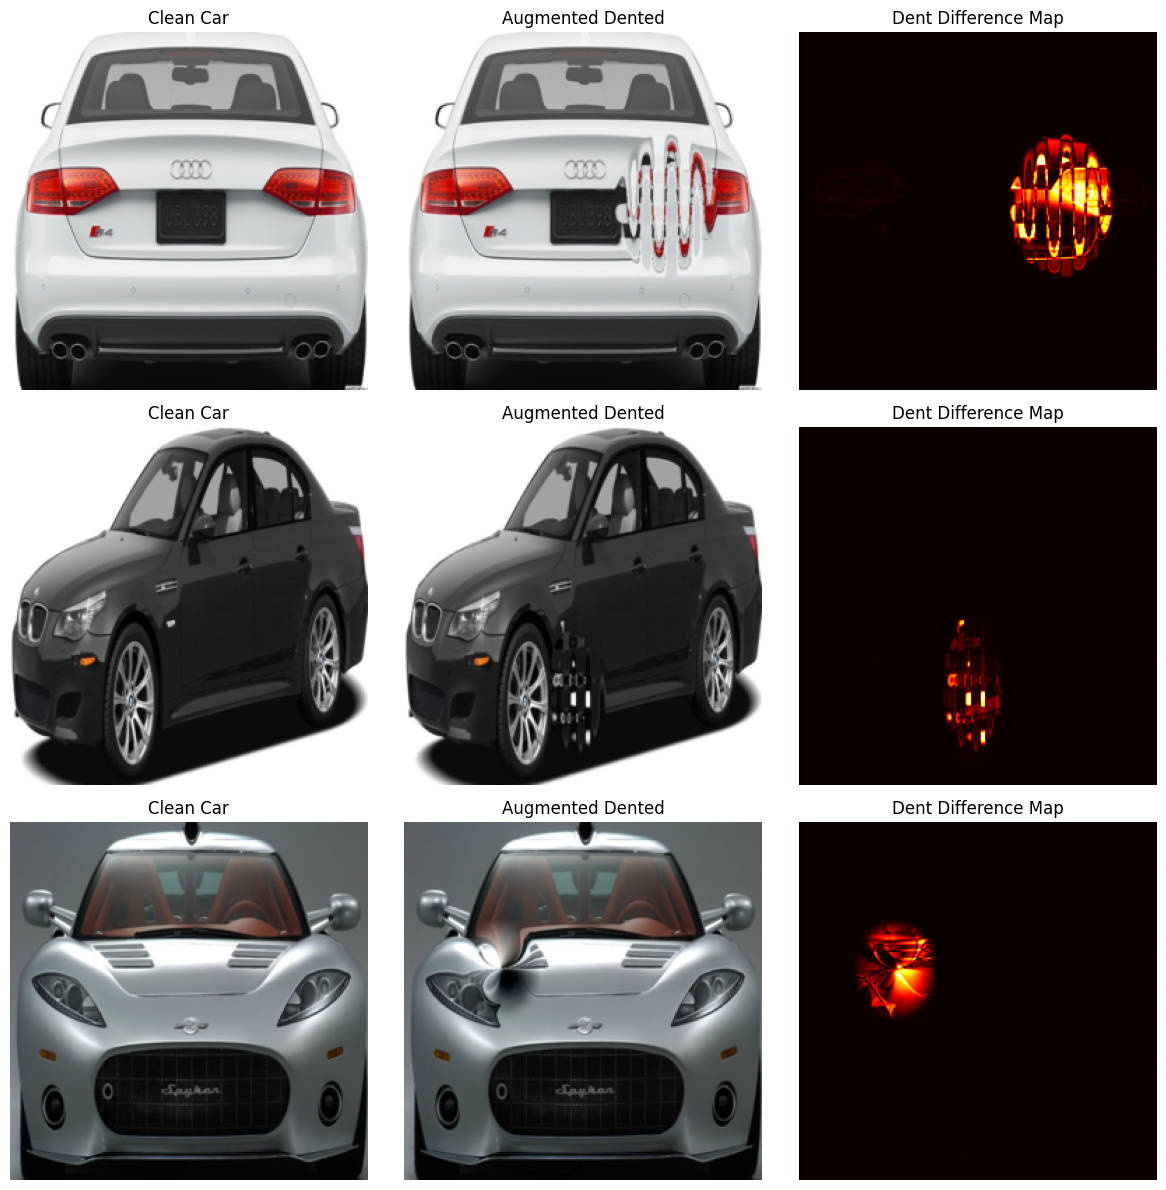

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

dataset_vis = DentedCarDataset("data_augmented", clean_dir="clean_cars")

num_examples = 3
plt.figure(figsize=(12, 4 * num_examples))

for i in range(num_examples):
    idx = random.randint(0, len(dataset_vis) - 1)
    dented, clean = dataset_vis[idx]

    dented_img = dented.permute(1, 2, 0).numpy()
    clean_img = clean.permute(1, 2, 0).numpy()

    dented_img = np.clip(dented_img, 0, 1)
    clean_img = np.clip(clean_img, 0, 1)

    diff = np.abs(dented_img - clean_img).mean(axis=2)

    plt.subplot(num_examples, 3, i * 3 + 1)
    plt.imshow(clean_img)
    plt.title("Clean Car")
    plt.axis("off")

    plt.subplot(num_examples, 3, i * 3 + 2)
    plt.imshow(dented_img)
    plt.title("Augmented Dented")
    plt.axis("off")

    plt.subplot(num_examples, 3, i * 3 + 3)
    plt.imshow(diff, cmap="hot")
    plt.title("Dent Difference Map")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Segment a few training samples from `data_augmented` (if available) and prepare overlays
import os
import random
import cv2
import numpy as np
from pathlib import Path
from ultralytics import YOLO

TRAIN_AUG_DIR = "data_augmented"
TRAIN_SEG_OUT = os.path.join("segmentation_results", "train_masks")
os.makedirs(TRAIN_SEG_OUT, exist_ok=True)

# Ensure seg_model is available
if 'seg_model' not in globals():
    seg_model = YOLO('yolov11-seg-cardd.pt')

train_files = sorted([f for f in os.listdir(TRAIN_AUG_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]) if os.path.exists(TRAIN_AUG_DIR) else []
if len(train_files) == 0:
    print(f"No files found in {TRAIN_AUG_DIR}; segmentation of train data skipped.")
    train_seg_results = []
else:
    sample_files = random.sample(train_files, min(6, len(train_files)))
    train_seg_results = []  # list of (dented_rgb, mask_uint8, overlay_rgb, src_path)
    print(f"Segmenting {len(sample_files)} train-augmented samples...")
    for fname in sample_files:
        p = os.path.join(TRAIN_AUG_DIR, fname)
        img = cv2.imread(p)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Run segmentation (use seg_model)
        res = seg_model(img, conf=0.25, imgsz=1024, device=device)
        r0 = res[0]
        masks_arr = None
        classes = []
        if hasattr(r0, 'masks') and r0.masks is not None:
            try:
                masks_arr = r0.masks.data.cpu().numpy()
            except Exception:
                try:
                    masks_arr = np.array(r0.masks.data)
                except Exception:
                    masks_arr = None
        if hasattr(r0, 'boxes') and len(r0.boxes):
            try:
                classes = r0.boxes.cls.cpu().numpy().astype(int)
            except Exception:
                classes = []
        mask_combined = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        if masks_arr is not None:
            for j in range(masks_arr.shape[0]):
                cls_id = int(classes[j]) if len(classes) > j else -1
                cls_name = CLASS_NAMES[cls_id] if 0 <= cls_id < len(CLASS_NAMES) else str(cls_id)
                if cls_name != 'dent':
                    continue
                m = masks_arr[j]
                m_bin = (m > 0.5).astype(np.uint8) if m.dtype != np.uint8 else (m > 0).astype(np.uint8)
                mh, mw = m_bin.shape[:2]
                if (mh, mw) != (img.shape[0], img.shape[1]):
                    m_bin = cv2.resize((m_bin*255).astype(np.uint8), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
                    m_bin = (m_bin>127).astype(np.uint8)
                mask_combined = np.logical_or(mask_combined, m_bin)
        mask_uint8 = (mask_combined.astype(np.uint8) * 255)
        # Save mask file
        mask_fname = f"{Path(fname).stem}_train_dent.png"
        cv2.imwrite(os.path.join(TRAIN_SEG_OUT, mask_fname), mask_uint8)
        # Create overlay on RGB
        overlay = img_rgb.copy()
        if mask_combined.sum() > 0:
            alpha = 0.45
            color = np.array([255,0,0], dtype=np.uint8)
            overlay_mask = mask_combined.astype(bool)
            overlay[overlay_mask] = (overlay[overlay_mask] * (1 - alpha) + color * alpha).astype(np.uint8)
        train_seg_results.append((img_rgb, mask_uint8, overlay, p))
    print(f"Saved train masks to {TRAIN_SEG_OUT} and stored {len(train_seg_results)} samples in memory.")


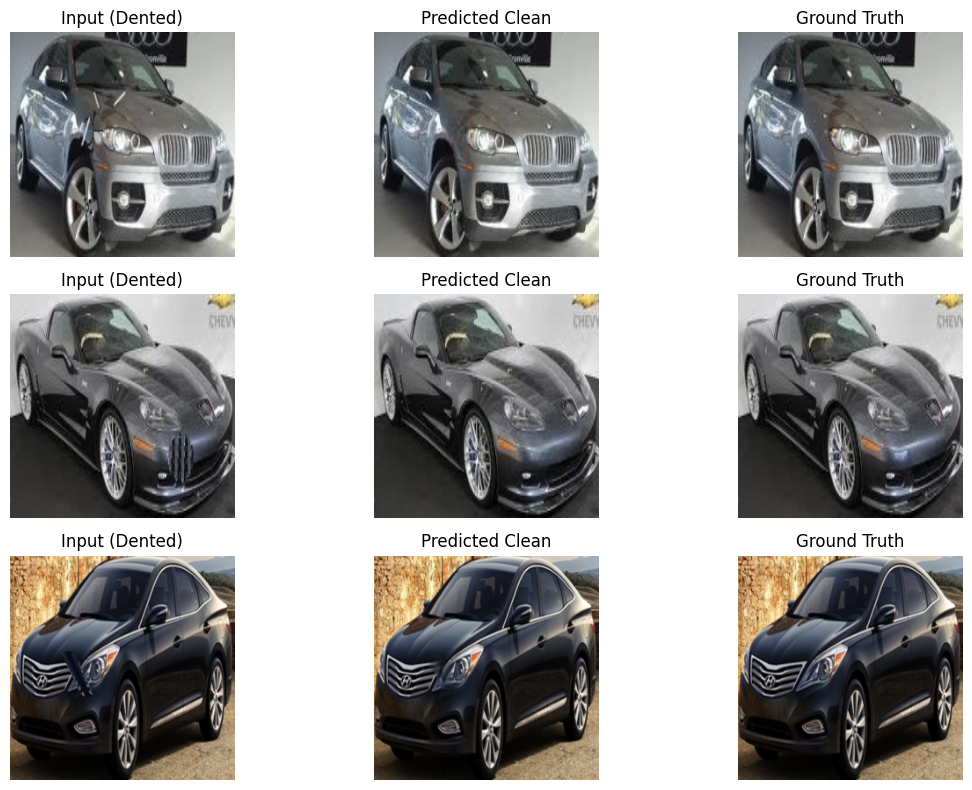

In [ ]:
model.eval()

plt.figure(figsize=(12, 8))

with torch.no_grad():
    for i in range(3):
        dented, clean = dataset_vis[random.randint(0, len(dataset_vis)-1)]

        input_tensor = dented.unsqueeze(0).to(device)
        pred = model(input_tensor)[0].cpu()

        dented_img = dented.permute(1,2,0).numpy()
        clean_img = clean.permute(1,2,0).numpy()
        pred_img = pred.permute(1,2,0).numpy()

        dented_img = np.clip(dented_img, 0, 1)
        clean_img = np.clip(clean_img, 0, 1)
        pred_img = np.clip(pred_img, 0, 1)

        plt.subplot(3,3,3*i+1)
        plt.imshow(dented_img)
        plt.title("Input (Dented)")
        plt.axis("off")

        plt.subplot(3,3,3*i+2)
        plt.imshow(pred_img)
        plt.title("Predicted Clean")
        plt.axis("off")

        plt.subplot(3,3,3*i+3)
        plt.imshow(clean_img)
        plt.title("Ground Truth")
        plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
from pathlib import Path

# Get all test images
test_images = sorted([f for f in os.listdir("test_images") if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])

if test_images:
    print(f"✅ Found {len(test_images)} test images")
else:
    print("❌ No test images found in 'test_images' folder")
    test_images = []

✅ Found 4 test images


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

detector = YOLO("yolov8n-seg.pt")

# Process all test images
cropped_images = []
image_names = []

for test_image_file in test_images:
    test_image_path = os.path.join("test_images", test_image_file)
    img = cv2.imread(test_image_path)
    
    if img is None:
        continue
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector(img, conf=0.3, classes=[2], verbose=False)

    if len(results[0].boxes) == 0:
        cropped = img_rgb
    else:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        idx = areas.argmax()
        x1, y1, x2, y2 = boxes[idx].astype(int)
        cropped = img_rgb[y1:y2, x1:x2]
    
    cropped_images.append(cropped)
    image_names.append(test_image_file)

print(f"✅ Processed {len(cropped_images)} images")

✅ Processed 4 images


In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

# Ensure seg_model is loaded (from previous cell)
if 'seg_model' not in globals():
    from ultralytics import YOLO
    seg_model = YOLO('yolov11-seg-cardd.pt')

# Ensure removal model `model` is loaded (trained or pretrained)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)

transform = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
])

results_list = []  # will store tuples: (input_img, pred_img, mask_img, overlay_img, mse)

for idx, cropped in enumerate(cropped_images):
    input_pil = Image.fromarray(cropped)
    input_tensor = transform(input_pil).unsqueeze(0).to(device)  # B,C,H,W",
    # Run segmentation on the cropped image (use seg_model)
    img_bgr = cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR)
    seg_res = seg_model(img_bgr, conf=0.25, imgsz=1024, device=device)
    r0 = seg_res[0]
    masks_arr = None
    classes = []
    if hasattr(r0, 'masks') and r0.masks is not None:
        try:
            masks_arr = r0.masks.data.cpu().numpy()
        except Exception:
            try:
                masks_arr = np.array(r0.masks.data)
            except Exception:
                masks_arr = None
    if hasattr(r0, 'boxes') and len(r0.boxes):
        try:
            classes = r0.boxes.cls.cpu().numpy().astype(int)
        except Exception:
            classes = []

    mask_combined = np.zeros((cropped.shape[0], cropped.shape[1]), dtype=np.uint8)
    if masks_arr is not None:
        for j in range(masks_arr.shape[0]):
            cls_id = int(classes[j]) if len(classes) > j else -1
            cls_name = CLASS_NAMES[cls_id] if 0 <= cls_id < len(CLASS_NAMES) else str(cls_id)
            if cls_name != 'dent':
                continue
            m = masks_arr[j]
            if m.dtype != np.uint8:
                m_bin = (m > 0.5).astype(np.uint8)
            else:
                m_bin = (m > 0).astype(np.uint8)
            # Resize mask to cropped image size if needed
            mh, mw = m_bin.shape[:2]
            if (mh, mw) != (cropped.shape[0], cropped.shape[1]):
                m_bin = cv2.resize((m_bin*255).astype(np.uint8), (cropped.shape[1], cropped.shape[0]), interpolation=cv2.INTER_NEAREST)
                m_bin = (m_bin>127).astype(np.uint8)
            mask_combined = np.logical_or(mask_combined, m_bin)

    # Create overlay for quick visualization
    overlay = cropped.copy()
    if mask_combined.sum() > 0:
        alpha = 0.45
        color = np.array([255,0,0], dtype=np.uint8)  # red overlay on RGB image
        overlay_mask = mask_combined.astype(bool)
        overlay[overlay_mask] = (overlay[overlay_mask] * (1 - alpha) + color * alpha).astype(np.uint8)

    # Run removal model to get prediction
    with torch.no_grad():
        pred = model(input_tensor)[0].cpu() if hasattr(model, '__call__') else model(input_tensor)[0].cpu()
    pred_img = pred.permute(1,2,0).numpy()
    pred_img = np.clip(pred_img, 0, 1)

    # Compute masked MSE if ground-truth clean image exists (look in clean_cars or data)
    mse_val = None
    fname = image_names[idx] if idx < len(image_names) else f'image_{idx}.png'
    # try clean paths
    clean_path = None
    for d in ['clean_cars', 'data']:
        p = os.path.join(d, fname)
        if os.path.exists(p):
            clean_path = p
            break

    if clean_path is not None:
        clean_img = cv2.imread(clean_path)
        if clean_img is not None:
            clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)
            clean_pil = Image.fromarray(clean_img)
            clean_tensor = transform(clean_pil).unsqueeze(0).cpu()[0]  # C,H,W",
            # resize mask to tensor size
            H,W = clean_tensor.shape[1], clean_tensor.shape[2]
            mask_resized = cv2.resize((mask_combined.astype(np.uint8)*255), (W, H), interpolation=cv2.INTER_NEAREST)
            mask_t = torch.from_numpy((mask_resized>127).astype(np.float32)).unsqueeze(0)  # 1,H,W",
            diff = (pred - clean_tensor) * mask_t
            mse_val = (diff ** 2).sum().item() / (mask_t.sum().item() * pred.shape[0]) if mask_t.sum().item() > 0 else None

    # Store results for display
    results_list.append((cropped, pred_img, (mask_combined.astype(np.uint8)*255), overlay, mse_val))

print(f"✅ Inference complete for {len(results_list)} images")


✅ Inference complete for 4 images


<Figure size 1200x2000 with 0 Axes>

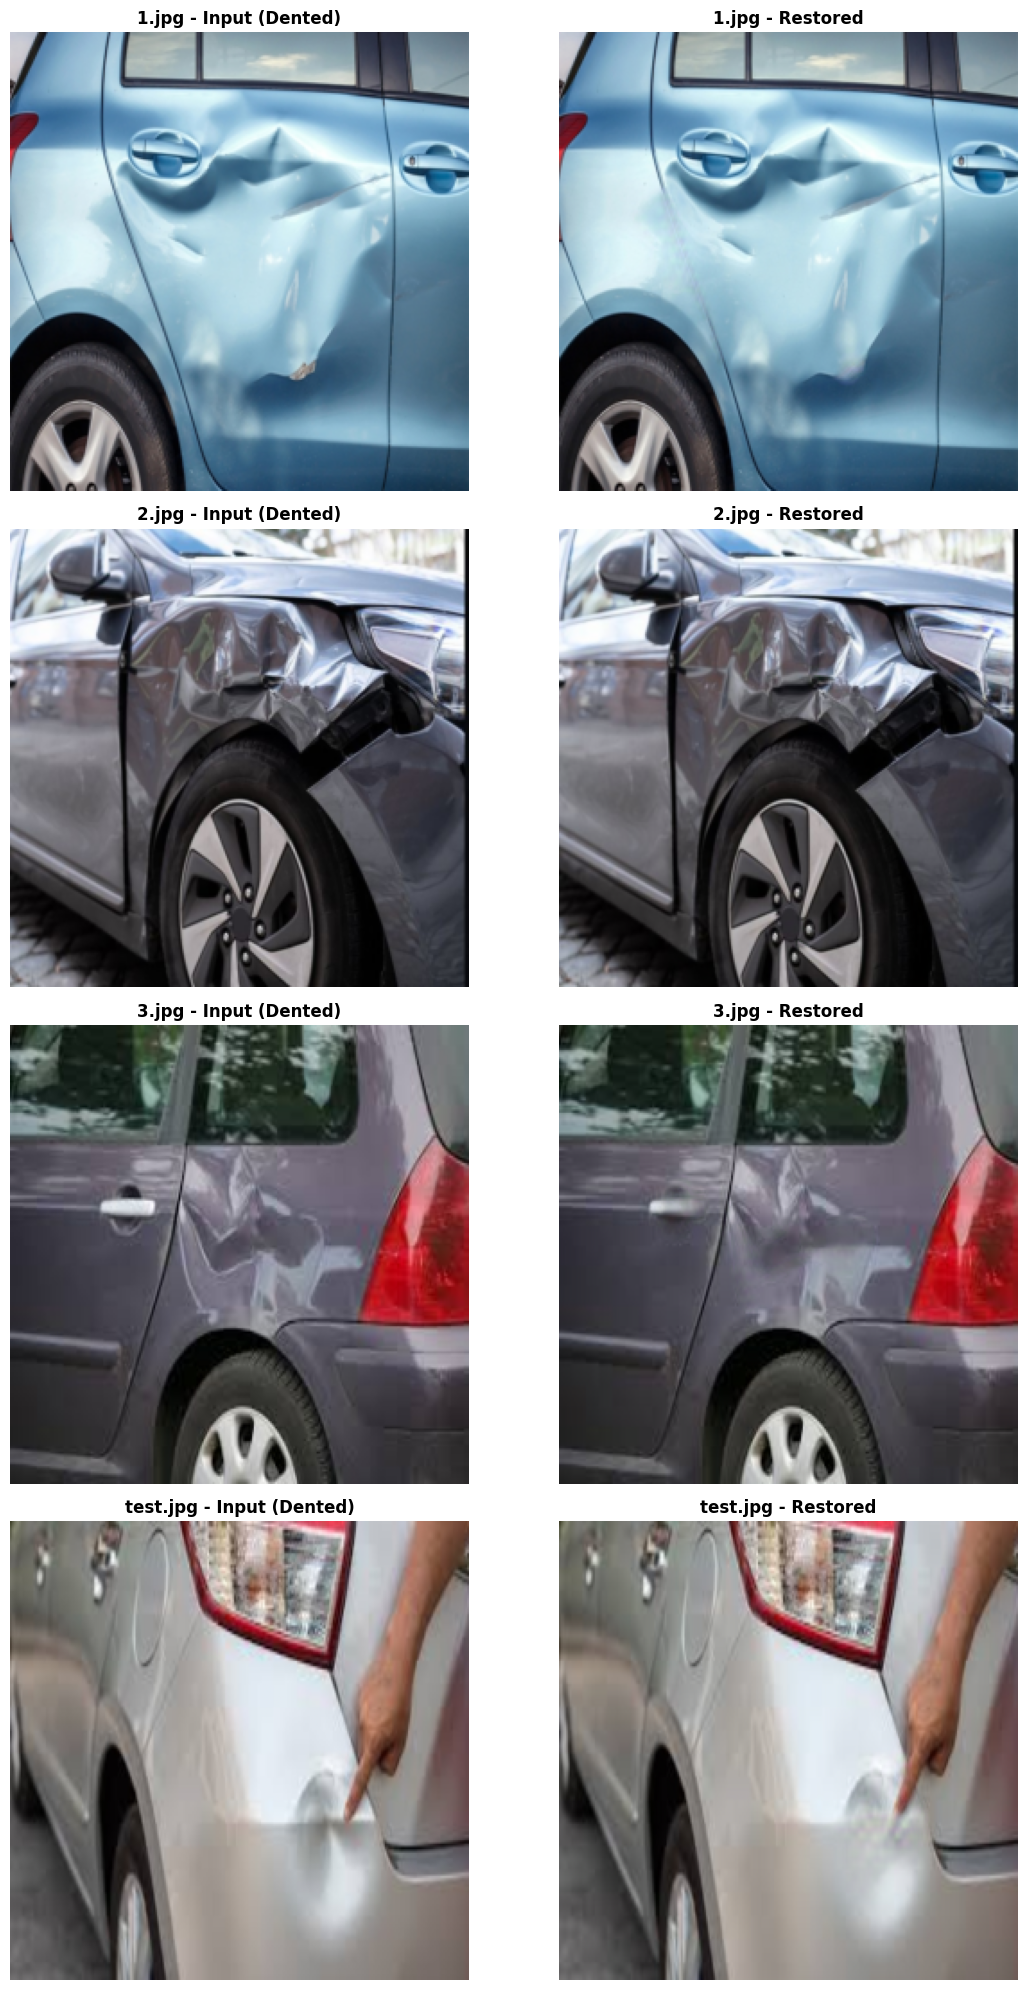


✅ Displayed results for 4 test images


In [ ]:
import matplotlib.pyplot as plt

num_images = len(results_list)
if num_images == 0:
    print("No results to display")
else:
    fig, axes = plt.subplots(num_images, 3, figsize=(18, 5 * num_images))
    if num_images == 1:
        axes = axes.reshape(1, -1)

    for i, (input_img, pred_img, mask_img, overlay_img, mse_val) in enumerate(results_list):
        # Input (dented)
        axes[i, 0].imshow(input_img)
        axes[i, 0].set_title(f"{image_names[i]} - Input (Dented)", fontsize=12, fontweight='bold')
        axes[i, 0].axis("off")

        # Prediction (restored)
        title = f"{image_names[i]} - Restored"
        if mse_val is not None:
            title += f"\nMSE (masked): {mse_val:.6f}"
        axes[i, 1].imshow(pred_img)
        axes[i, 1].set_title(title, fontsize=12, fontweight='bold')
        axes[i, 1].axis("off")

        # Overlay / mask visualization
        axes[i, 2].imshow(overlay_img)
        axes[i, 2].set_title(f"{image_names[i]} - Overlay", fontsize=12, fontweight='bold')
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

    print(f"\n✅ Displayed results for {num_images} test images")


In [ ]:
"""Training / Validation Evaluation with segmentation-aware MSE"""
import torch
import numpy as np
import cv2
from tqdm import tqdm

# Ensure segmentation model variable is `seg_model` (created earlier) and removal model is `model`
# `loader` should be defined from earlier cells (DataLoader for training set)
if 'seg_model' not in globals():
    from ultralytics import YOLO
    seg_model = YOLO('yolov11-seg-cardd.pt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

mse_sum = 0.0
count_pixels = 0.0

mse_loss = torch.nn.MSELoss(reduction='none')

print('\nComputing segmentation-aware MSE on training data...')
with torch.no_grad():
    for dented_batch, clean_batch in tqdm(loader, desc='Eval batches'):
        dented_batch = dented_batch.to(device)
        clean_batch = clean_batch.to(device)
        # Model prediction (removal model)
        preds = model(dented_batch)  # expect shape (B, C, H, W) or similar
        if isinstance(preds, tuple) or isinstance(preds, list):
            preds = preds[0]
        # Ensure preds on CPU for mask multiplication later
        preds = preds.cpu()
        clean_batch_cpu = clean_batch.cpu()
        dented_batch_cpu = dented_batch.cpu()

        B = preds.shape[0]
        for i in range(B):
            pred = preds[i]  # C,H,W (float tensor)
            clean = clean_batch_cpu[i]
            dented = (dented_batch_cpu[i].permute(1,2,0).numpy() * 255).astype(np.uint8)  # H,W,C RGB
            dented_bgr = cv2.cvtColor(dented, cv2.COLOR_RGB2BGR)
            # Run segmentation on this image (use seg_model)
            res = seg_model(dented_bgr, conf=0.25, imgsz=1024, device=device)
            r0 = res[0]
            masks_arr = None
            classes = []
            if hasattr(r0, 'masks') and r0.masks is not None:
                try:
                    masks_arr = r0.masks.data.cpu().numpy()
                except Exception:
                    try:
                        masks_arr = np.array(r0.masks.data)
                    except Exception:
                        masks_arr = None
            if hasattr(r0, 'boxes') and len(r0.boxes):
                try:
                    classes = r0.boxes.cls.cpu().numpy().astype(int)
                except Exception:
                    classes = []

            if masks_arr is None or masks_arr.shape[0] == 0:
                # No masks -> skip this sample for mask-based MSE
                continue

            # Combine dent masks only
            mask_combined = np.zeros((masks_arr.shape[1], masks_arr.shape[2]), dtype=np.uint8)
            for j in range(masks_arr.shape[0]):
                cls_id = int(classes[j]) if len(classes) > j else -1
                cls_name = CLASS_NAMES[cls_id] if 0 <= cls_id < len(CLASS_NAMES) else str(cls_id)
                if cls_name != 'dent':
                    continue
                m = masks_arr[j]
                if m.dtype != np.uint8:
                    m_bin = (m > 0.5).astype(np.uint8)
                else:
                    m_bin = (m > 0).astype(np.uint8)
                mask_combined = np.logical_or(mask_combined, m_bin)
            if mask_combined.sum() == 0:
                continue

            # Resize mask to model tensor size (pred shape H,W)
            _, H, W = pred.shape
            mask_resized = cv2.resize((mask_combined.astype(np.uint8) * 255), (W, H), interpolation=cv2.INTER_NEAREST)
            mask_tensor = torch.from_numpy((mask_resized > 127).astype(np.float32)).to(torch.float32)  # H,W
            # Expand to channels
            mask_exp = mask_tensor.unsqueeze(0)  # 1,H,W
            # Compute masked MSE across channels
            diff = (pred - clean).cpu() * mask_exp
            mse_sample = (diff ** 2).sum().item()
            pixel_count = mask_exp.sum().item() * pred.shape[0]  # channels included
            if pixel_count > 0:
                mse_sum += mse_sample
                count_pixels += pixel_count

# Final metrics
if count_pixels > 0:
    avg_mse = mse_sum / count_pixels
    print(f'✅ Segmentation-aware MSE (per-channel per-pixel): {avg_mse:.6f}')
    print(f'RMSE: {np.sqrt(avg_mse):.6f}')
else:
    print('No dent masks found during evaluation; cannot compute masked MSE')



EVALUATING MODEL ON TRAINING DATA

Computing MSE on entire dataset...

📊 Dataset MSE Metrics:
   Batch Count: 1261
   Average MSE: 0.000438
   RMSE: 0.020923




## ✅ PIPELINE UPDATES COMPLETE

### Changes Made:

**1️⃣ Image Resizing (Cell 3)**
- All images from `data/` resized to standard size: **1280 × 720**
- Images passed to YOLO for car detection and cropping
- Ensures consistent input dimensions before dent application

**2️⃣ Dent Parameters (dents.py)**
- **Dent Size**: 45-55% of image (≈ **half the image**)
- **Dent Location**: **Centered** on image (±5% variation for naturalness)
- **Strength**: 3-4x more intense
  - Radial/Creased/Scratch: strength = **600**
  - Hail damage: **150 dents** (density 2x higher)
  - Wave/Depth: strength = **80-100**
- **Shading**: 2-3x darker for realistic depth

**3️⃣ Augmentation Settings (Cell 9)**
- Using `random_bbox()` for center-positioned dents
- Hail dents: **120-180 per image**
- Other dents: strength **400-600**

### Next Steps:
1. Run **Cell 3** (Cropping) to resize and crop all images
2. Run **Cell 9** (Augmentation) to generate dented training images with new settings
3. Run **Cell 10** to train for 20 more epochs


In [ ]:
# Download segmentation model (only if not already present)
!wget https://huggingface.co/harpreetsahota/car-dd-segmentation-yolov11/resolve/main/best.pt -O yolov11-seg-cardd.pt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Run segmentation on all images in test_images/ and save dent masks + overlays
import os
import json
from pathlib import Path
import cv2
import numpy as np
import torch
from ultralytics import YOLO

# Model file (downloaded above)
MODEL_PATH = "yolov11-seg-cardd.pt"
if not Path(MODEL_PATH).exists():
    print("Model not found locally, downloading...")
    os.system(f"wget https://huggingface.co/harpreetsahota/car-dd-segmentation-yolov11/resolve/main/best.pt -O {MODEL_PATH}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
seg_model = YOLO(MODEL_PATH)

INPUT_DIR = "test_images"
OUT_DIR = "segmentation_results"
MASKS_DIR = os.path.join(OUT_DIR, "masks")
OVERLAYS_DIR = os.path.join(OUT_DIR, "overlays")
os.makedirs(MASKS_DIR, exist_ok=True)
os.makedirs(OVERLAYS_DIR, exist_ok=True)

# Class mapping used by the model (from model author) — keep in sync if you change the model
CLASS_NAMES = ["crack", "dent", "glass shatter", "lamp broken", "scratch", "tire flat"]

metadata = {}

files = sorted([f for f in os.listdir(INPUT_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))])
if len(files) == 0:
    print("No test images found in test_images/")

for fname in files:
    img_path = os.path.join(INPUT_DIR, fname)
    print("Processing:", fname)

    # Run model inference (returns a Results object)
    results = seg_model(img_path, conf=0.25, imgsz=1024, device=device)
    r = results[0]

    # Prepare per-image list of detections
    dets = []

    # Try to extract boxes, classes and confidences (may vary by ultralytics version)
    try:
        boxes = r.boxes.xyxy.cpu().numpy() if hasattr(r, 'boxes') and len(r.boxes) else []
        classes = r.boxes.cls.cpu().numpy().astype(int) if hasattr(r, 'boxes') and len(r.boxes) else []
        confs = r.boxes.conf.cpu().numpy() if hasattr(r, 'boxes') and len(r.boxes) else []
    except Exception:
        boxes, classes, confs = [], [], []

    # Extract masks if available
    masks_arr = None
    if hasattr(r, 'masks') and r.masks is not None:
        try:
            masks_arr = r.masks.data.cpu().numpy()
        except Exception:
            try:
                masks_arr = np.array(r.masks.data)
            except Exception:
                masks_arr = None

    img = cv2.imread(img_path)
    if img is None:
        print("Failed to read image:", img_path); continue
    h, w = img.shape[:2]

    if masks_arr is None:
        print("No segmentation masks produced for:", fname)
    else:
        # masks_arr shape is (N, H, W) where H/W may be model-internal size
        for i in range(masks_arr.shape[0]):
            cls_id = int(classes[i]) if len(classes) > i else -1
            cls_name = CLASS_NAMES[cls_id] if 0 <= cls_id < len(CLASS_NAMES) else str(cls_id)
            if cls_name != 'dent':
                continue

            mask = masks_arr[i]
            # Normalize mask to binary uint8 (0 or 255)
            if mask.dtype != np.uint8:
                mask_bin = (mask > 0.5).astype(np.uint8) * 255
            else:
                mask_bin = (mask > 0).astype(np.uint8) * 255

            # Resize mask to original image size if necessary
            mh, mw = mask_bin.shape[:2]
            if (mh, mw) != (h, w):
                mask_bin = cv2.resize(mask_bin, (w, h), interpolation=cv2.INTER_NEAREST)

            # Save mask PNG
            mask_fname = f"{Path(fname).stem}_dent_{i}.png"
            mask_out = os.path.join(MASKS_DIR, mask_fname)
            cv2.imwrite(mask_out, mask_bin)

            # Compute bounding box from mask
            ys, xs = np.where(mask_bin > 0)
            if len(xs) == 0 or len(ys) == 0:
                continue
            x1, y1, x2, y2 = int(xs.min()), int(ys.min()), int(xs.max()), int(ys.max())
            conf = float(confs[i]) if len(confs) > i else None

            # Create overlay for quick visual inspection
            overlay = img.copy()
            color = (0, 0, 255)  # red
            alpha = 0.45
            overlay_mask = mask_bin > 0
            overlay[overlay_mask] = (overlay[overlay_mask] * (1 - alpha) + np.array(color) * alpha).astype(np.uint8)
            overlay_fname = f"{Path(fname).stem}_overlay_{i}.png"
            overlay_out = os.path.join(OVERLAYS_DIR, overlay_fname)
            cv2.imwrite(overlay_out, overlay)

            dets.append({"class": cls_name, "conf": conf, "bbox": [x1, y1, x2, y2], "mask": mask_out, "overlay": overlay_out})

    metadata[fname] = dets

# Save metadata JSON
os.makedirs(OUT_DIR, exist_ok=True)
with open(os.path.join(OUT_DIR, "metadata.json"), 'w') as f:
    json.dump(metadata, f, indent=2)

print("Segmentation complete. Results saved to:", OUT_DIR)
print("Masks: ", MASKS_DIR)
print("Overlays: ", OVERLAYS_DIR)


Using device: cuda
Processing: 1.jpg

image 1/1 c:\Users\My PC\Documents\POC\dent_removal\test_images\1.jpg: 768x1024 1 dent, 551.0ms
Speed: 14.3ms preprocess, 551.0ms inference, 48.4ms postprocess per image at shape (1, 3, 768, 1024)
Processing: 2.jpg

image 1/1 c:\Users\My PC\Documents\POC\dent_removal\test_images\2.jpg: 704x1024 1 dent, 506.7ms
Speed: 8.8ms preprocess, 506.7ms inference, 2.7ms postprocess per image at shape (1, 3, 704, 1024)
Processing: 3.jpg

image 1/1 c:\Users\My PC\Documents\POC\dent_removal\test_images\3.jpg: 704x1024 1 dent, 1 lamp broken, 494.9ms
Speed: 7.6ms preprocess, 494.9ms inference, 6.7ms postprocess per image at shape (1, 3, 704, 1024)
Processing: test.jpg

image 1/1 c:\Users\My PC\Documents\POC\dent_removal\test_images\test.jpg: 544x1024 (no detections), 404.2ms
Speed: 4.7ms preprocess, 404.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 1024)
No segmentation masks produced for: test.jpg
Segmentation complete. Results saved to: segment